In [1]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.graphics.factorplots import interaction_plot
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns
from itertools import cycle
import random


In [2]:
data_phil_clean= pd.read_csv("Clean Data/data_phil_clean_103122.csv")

In [3]:
#The index repopulates when the data is saved and then read again -- deleting the unneeded index for cleaner data 
data_phil_clean.drop(data_phil_clean.columns [0], axis= 1, inplace= True)

#Checking the list of column names 
#list(data_phil_clean.columns)

In [4]:
#Descriptive Statistics for the list of dependent variables 

print(data_phil_clean[['Av_FI', 'Av_FA', 'Av_PC', 'Av_WOM']].describe())


          Av_FI      Av_FA      Av_PC     Av_WOM
count  80.00000  80.000000  80.000000  80.000000
mean    3.43800   3.671875   5.746875   3.695500
std     1.33584   1.356882   0.910986   1.454662
min     1.00000   1.000000   3.000000   1.000000
25%     2.33000   2.500000   5.250000   2.330000
50%     3.67000   3.500000   6.000000   3.835000
75%     4.33000   4.750000   6.250000   4.670000
max     6.00000   6.500000   7.000000   7.000000


Text(0.5, 1.0, 'Correlation heatmap for dependent variables')

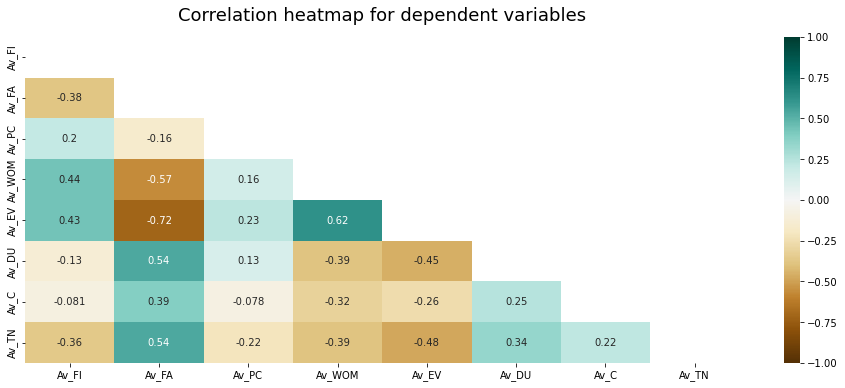

In [5]:
#Running correlations between variables and including a heatmap

data_corr = data_phil_clean.loc[:, 'Av_FI': 'Av_TN']
mask = np.triu(np.ones_like(data_corr.corr(), dtype =bool))
plt.figure (figsize = (16,6))
heatmap= sns.heatmap(data_corr.corr(), mask = mask, vmin = -1, vmax =1, annot= True, cmap= 'BrBG')
heatmap.set_title ('Correlation heatmap for dependent variables', fontdict ={'fontsize':18} , pad = 16)

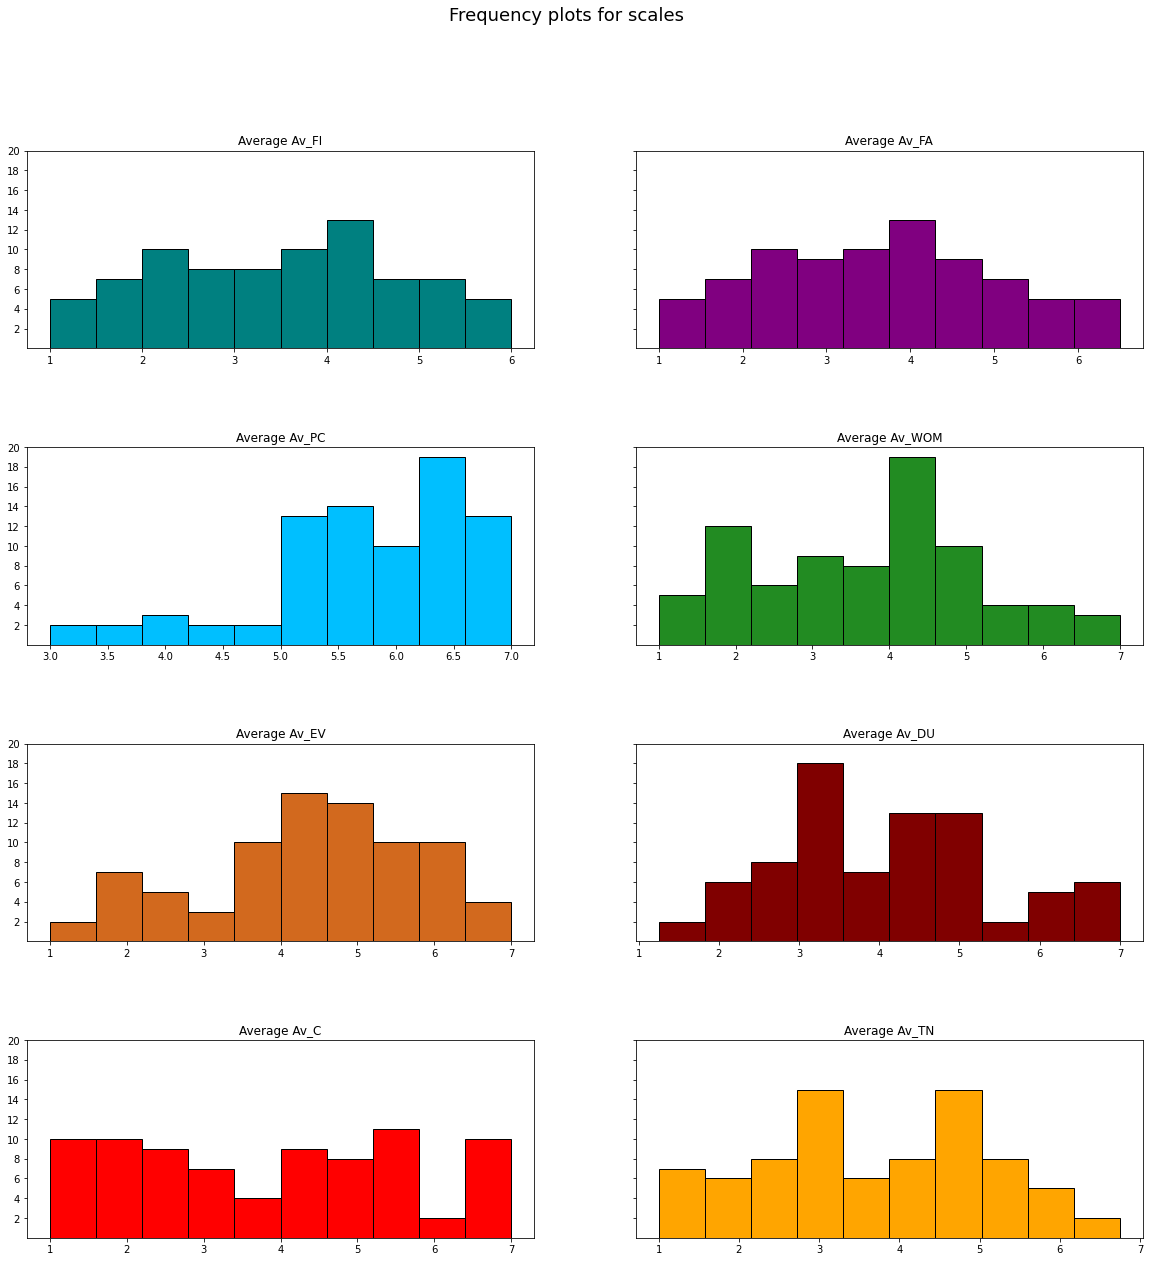

In [6]:
#Creating plots to examine dependent variable frequencies
colors = ['teal', 'purple', 'deepskyblue', 'forestgreen', 'chocolate', 'maroon', 'red', 'orange']
cycol = cycle (colors)

fig, axes = plt.subplots (nrows = 4, ncols = 2, figsize = (20,20), sharey = 'row')

plt.subplots_adjust(wspace = 0.2, hspace = 0.5)

fig.suptitle ('Frequency plots for scales', fontsize= 18)

for col, ax in zip (data_corr.columns, axes.flatten()):
    ax.hist(data_corr[col], bins = 10, color = next(cycol), edgecolor ='black')
    ax.set_yticks ([2,4,6,8,10,12,14,16,18,20])
    ax.set_title('Average ' + col)

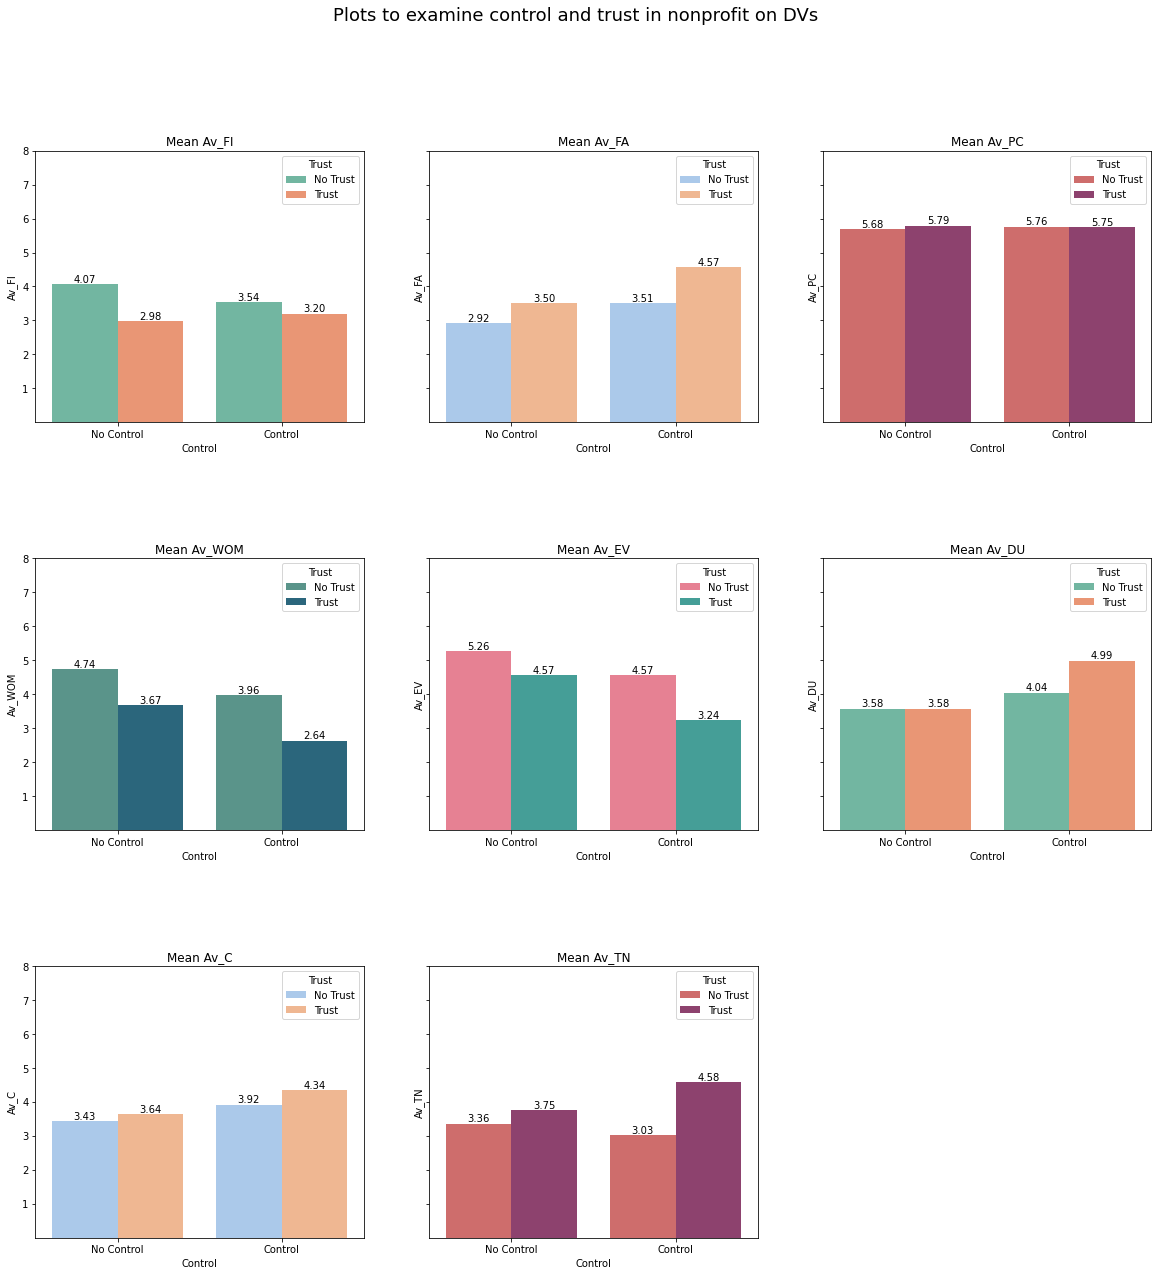

In [7]:
#Cycling through palettes
palette = ['Set2', 'pastel', 'flare', 'crest', 'husl']
palette = cycle (palette)

#Testing if the manipulation of control worked - perceptions of control should differ between conditions of control
fig, axes = plt.subplots (nrows = 3, ncols = 3, figsize = (20,20), sharey = 'row', edgecolor ='Black')
fig.delaxes(axes[2][2])
plt.subplots_adjust(wspace = 0.2, hspace = 0.5)
fig.suptitle ('Plots to examine control and trust in nonprofit on DVs', fontsize = 18)

for col, ax in zip (data_corr.columns, axes.flatten()):
    sns.barplot(ax = ax, data= data_phil_clean, x= 'Control', y= data_phil_clean[col], hue='Trust', palette = next (palette), ci= None)
    ax.set_yticks ([1,2,3,4,5,6,7,8])
    ax.set_xticklabels (['No Control', 'Control'])
    ax.set_title ('Mean' + ' '+ col)
    ax.legend(title ='Trust', labels =['No Trust', 'Trust'])
    for bars in ax.containers:
        ax.bar_label(bars, fmt ='%.2f')
    
#plt.show()

In [8]:
####################### Printing out the means for the DVs #######################
print ('The means for the dependent variables based on the conditions')
print (data_phil_clean.groupby (['Control', 'Trust'])[['Av_FI', 'Av_FA', 'Av_PC', 'Av_WOM', 'Av_EV', 'Av_DU']].mean())
print ("\n")
print (data_phil_clean.groupby ('Control')[['Av_FI', 'Av_FA', 'Av_PC', 'Av_WOM', 'Av_EV', 'Av_DU']].mean())
print ('\n')
print (data_phil_clean.groupby ('Trust')[['Av_FI', 'Av_FA', 'Av_PC', 'Av_WOM', 'Av_EV', 'Av_DU']].mean())

The means for the dependent variables based on the conditions
                  Av_FI     Av_FA     Av_PC    Av_WOM     Av_EV     Av_DU
Control Trust                                                            
0.0     0.0    4.069474  2.921053  5.684211  4.735789  5.263158  3.578947
        1.0    2.983684  3.500000  5.789474  3.667895  4.565789  3.578947
1.0     0.0    3.544737  3.513158  5.763158  3.964211  4.565789  4.039474
        1.0    3.203478  4.565217  5.750000  2.636957  3.239130  4.989130


            Av_FI     Av_FA     Av_PC    Av_WOM     Av_EV     Av_DU
Control                                                            
0.0      3.526579  3.210526  5.736842  4.201842  4.914474  3.578947
1.0      3.357857  4.089286  5.755952  3.237381  3.839286  4.559524


          Av_FI     Av_FA     Av_PC    Av_WOM     Av_EV     Av_DU
Trust                                                            
0.0    3.807105  3.217105  5.723684  4.350000  4.914474  3.809211
1.0    3.104048  4.0

In [9]:
################## A function that wraps the ANOVA model for the dependent variables #####################

#dv is the dependent variable, x1 and x2 are the IV, condition is x1+x2 combined, data is data

def anova_model (dv, x1, x2, condition, data): 
    colors = ['teal', 'purple', 'deepskyblue', 'forestgreen', 'chocolate', 'maroon', 'red', 'orange']
    model = ols('dv ~ C(x1) + C(x2) + C(x1): C(x2)', data = data).fit()
    print (model.summary())
    print ('\n')
    print (sm.stats.anova_lm(model, typ = 2))
    print ('\n')
    
    #Tukey comparisons
    FI_comp = pairwise_tukeyhsd (endog = dv, groups = condition, alpha = 0.05)
    print (FI_comp)
    print ('\n')
    
    #Visualizing the interaction 
    fig = interaction_plot(x1, x2, dv, colors = [random.choice (colors), random.choice (colors)], markers = ['+', '*'], ms= 10)

                            OLS Regression Results                            
Dep. Variable:                     dv   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     4.863
Date:                Mon, 14 Nov 2022   Prob (F-statistic):            0.00379
Time:                        16:24:46   Log-Likelihood:                -138.31
No. Observations:                  80   AIC:                             284.6
Df Residuals:                      76   BIC:                             294.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

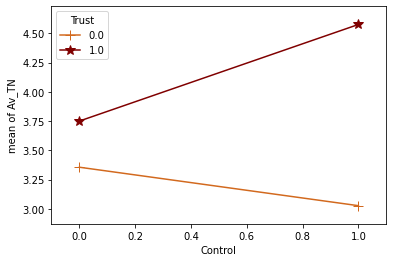

In [10]:
#ANOVA model for Average Trust in nonprofit 
anova_model (data_phil_clean['Av_TN'], data_phil_clean['Control'], data_phil_clean['Trust'], data_phil_clean['Condition'], data_phil_clean)

                            OLS Regression Results                            
Dep. Variable:                     dv   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.038
Method:                 Least Squares   F-statistic:                   0.04426
Date:                Mon, 14 Nov 2022   Prob (F-statistic):              0.988
Time:                        16:24:46   Log-Likelihood:                -105.48
No. Observations:                  80   AIC:                             219.0
Df Residuals:                      76   BIC:                             228.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

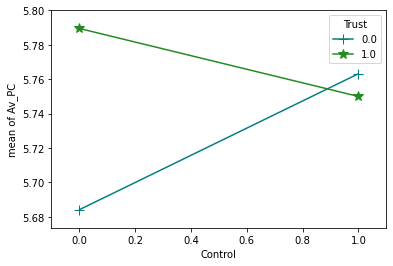

In [11]:
################## The ANOVA model for average perceived control over data #####################

anova_model (data_phil_clean['Av_PC'], data_phil_clean['Control'], data_phil_clean['Trust'], data_phil_clean['Condition'],data_phil_clean)



                            OLS Regression Results                            
Dep. Variable:                     dv   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     2.569
Date:                Mon, 14 Nov 2022   Prob (F-statistic):             0.0605
Time:                        16:24:47   Log-Likelihood:                -132.31
No. Observations:                  80   AIC:                             272.6
Df Residuals:                      76   BIC:                             282.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

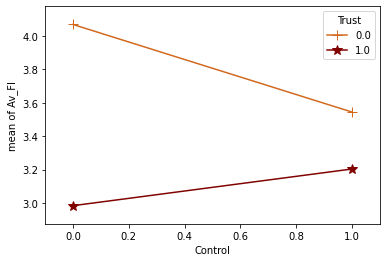

In [12]:
################## The ANOVA model for average Falsifying information #####################

anova_model (data_phil_clean['Av_FI'], data_phil_clean['Control'], data_phil_clean['Trust'], data_phil_clean['Condition'],data_phil_clean)

                            OLS Regression Results                            
Dep. Variable:                     dv   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     6.612
Date:                Mon, 14 Nov 2022   Prob (F-statistic):           0.000498
Time:                        16:24:48   Log-Likelihood:                -128.15
No. Observations:                  80   AIC:                             264.3
Df Residuals:                      76   BIC:                             273.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

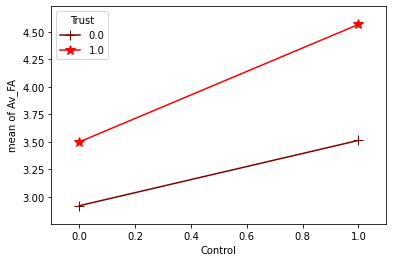

In [13]:
################## The ANOVA model for average perceived fairness #####################

anova_model (data_phil_clean['Av_FA'], data_phil_clean['Control'], data_phil_clean['Trust'], data_phil_clean['Condition'],data_phil_clean)




                            OLS Regression Results                            
Dep. Variable:                     dv   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.257
Method:                 Least Squares   F-statistic:                     10.12
Date:                Mon, 14 Nov 2022   Prob (F-statistic):           1.10e-05
Time:                        16:24:48   Log-Likelihood:                -129.55
No. Observations:                  80   AIC:                             267.1
Df Residuals:                      76   BIC:                             276.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

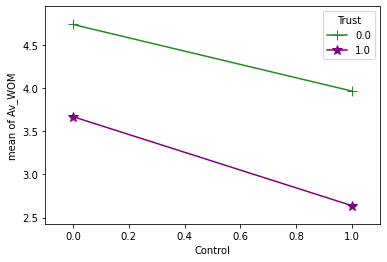

In [14]:
################## The ANOVA model for average word of mouth #####################

anova_model (data_phil_clean['Av_WOM'], data_phil_clean['Control'], data_phil_clean['Trust'], data_phil_clean['Condition'],data_phil_clean)


                            OLS Regression Results                            
Dep. Variable:                     dv   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     9.714
Date:                Mon, 14 Nov 2022   Prob (F-statistic):           1.68e-05
Time:                        16:24:49   Log-Likelihood:                -129.72
No. Observations:                  80   AIC:                             267.4
Df Residuals:                      76   BIC:                             277.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

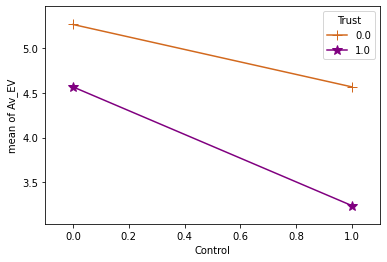

In [15]:
################## The ANOVA model for average perceived emotional violation #####################

anova_model (data_phil_clean['Av_EV'], data_phil_clean['Control'], data_phil_clean['Trust'], data_phil_clean['Condition'],data_phil_clean)




                            OLS Regression Results                            
Dep. Variable:                     dv   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.038
Method:                 Least Squares   F-statistic:                   0.04426
Date:                Mon, 14 Nov 2022   Prob (F-statistic):              0.988
Time:                        16:24:49   Log-Likelihood:                -105.48
No. Observations:                  80   AIC:                             219.0
Df Residuals:                      76   BIC:                             228.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

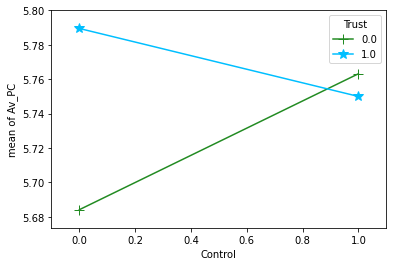

In [16]:
################## The ANOVA model for average data use transparency #####################

anova_model (data_phil_clean['Av_PC'], data_phil_clean['Control'], data_phil_clean['Trust'], data_phil_clean['Condition'],data_phil_clean)
